# 03 – Final NBA Model and Export

#### 1. Load Processed B2B Data
#### 2. Time-Based Train / Test Split
#### 3. Refit Final Logistic Regression (B2B)
#### 4. Evaluate and Inspect Coefficients
#### 5. Save Final Model Artifact

## 1. Load B2B Dataset

In [1]:
import sys 
from pathlib import Path 
import pandas as pd 

ROOT = Path("..").resolve()
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

from src.paths import PROCESSED_DIR

games = pd.read_parquet(PROCESSED_DIR / "processed_games_b2b_model.parquet")
games.head()

,date,start_et,away_team,home_team,attend,arena,season,source_file,home_win,home_win_pct_10,...,home_days_rest,home_last_pd,away_win_pct_10,away_avg_pd_10,away_season_win_pct,away_recent_win_pct_20g,away_days_rest,away_last_pd,home_b2b,away_b2b
0,2015-10-29,7:00p,Memphis Grizzlies,Indiana Pacers,18165.0,Bankers Life Fieldhouse,2015-16_NBA,oct.xls,0,0.0,...,1.0,-1.0,0.0,-1.0,0.0,0.0,1.0,-1.0,0,0
1,2015-10-29,8:00p,Atlanta Hawks,New York Knicks,19812.0,Madison Square Garden (IV),2015-16_NBA,oct.xls,0,1.0,...,1.0,1.0,0.0,-1.0,0.0,0.0,2.0,-1.0,0,0
2,2015-10-29,10:30p,Dallas Mavericks,Los Angeles Clippers,19218.0,STAPLES Center,2015-16_NBA,oct.xls,1,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,0
3,2015-10-30,10:30p,Portland Trail Blazers,Phoenix Suns,18055.0,Talking Stick Resort Arena,2015-16_NBA,oct.xls,1,0.0,...,2.0,-1.0,1.0,1.0,1.0,1.0,2.0,1.0,0,0
4,2015-10-30,10:00p,Los Angeles Lakers,Sacramento Kings,17391.0,Sleep Train Arena,2015-16_NBA,oct.xls,1,0.0,...,2.0,-1.0,0.0,-1.0,0.0,0.0,2.0,-1.0,0,0


## 2. Define Feature List

In [2]:
feature_cols = [
    # Rolling performance
    "home_win_pct_10", "away_win_pct_10",
    "home_avg_pd_10", "away_avg_pd_10",
    
    # Seasonal strength
    "home_season_win_pct", "away_season_win_pct",
    
    # Recent 20-game form
    "home_recent_win_pct_20g", "away_recent_win_pct_20g",
    
    # Rest days
    "home_days_rest", "away_days_rest",
    
    # Last game point differential
    "home_last_pd", "away_last_pd",
    
    # New: back-to-back flags
    "home_b2b", "away_b2b",
]

X = games[feature_cols]
y = games["home_win"]

## 3. Time-based Train/Test Split (more realistic)

In [3]:
games["season_year"] = games["date"].dt.year

# Example: train on seasons <= 2021, test on >= 2022
train_mask = games["season_year"] <= 2021
test_mask  = games["season_year"] >= 2022

X_train = X[train_mask]
y_train = y[train_mask]

X_test  = X[test_mask]
y_test  = y[test_mask]

X_train.shape, X_test.shape

((8073, 14), (3435, 14))

## 4. Refit Final Logistic Regression Model

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score

final_logreg = LogisticRegression(max_iter=1000, solver="lbfgs")
final_logreg.fit(X_train, y_train)

preds = final_logreg.predict(X_test)
proba = final_logreg.predict_proba(X_test)[:, 1]

final_acc = accuracy_score(y_test, preds)
final_auc = roc_auc_score(y_test, proba)

final_acc, final_auc

(0.6393013100436681, 0.6733032845338627)

### **Updated Model Performance (after improved B2B feature)**

The corrected back-to-back feature increased model performance further.

**Logistic Regression Results**
- **Accuracy:** 0.639  
- **ROC AUC:** 0.673  

**Interpretation:**  
Fixing the B2B calculation added real predictive value.  
This is now your strongest model to date and a reliable benchmark to finalize.


## 5. Inspect Coefficients

In [5]:
coef_df = pd.DataFrame({
    "feature": feature_cols,
    "coef": final_logreg.coef_[0],
}).sort_values("coef", ascending=False)

coef_df

,feature,coef
6,home_recent_win_pct_20g,1.534876
4,home_season_win_pct,1.223634
13,away_b2b,0.333772
2,home_avg_pd_10,0.141286
0,home_win_pct_10,0.092353
11,away_last_pd,0.044513
8,home_days_rest,0.001073
9,away_days_rest,0.000584
10,home_last_pd,-0.015844
1,away_win_pct_10,-0.038355


## 6. Train on all Data and Save Model Artifact

In [6]:
final_model = LogisticRegression(max_iter=1000, solver="lbfgs")
final_model.fit(X, y)  # X, y from ALL games

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [7]:
import joblib
from src.paths import MODEL_DIR

print("MODEL_DIR =", MODEL_DIR)
MODEL_DIR.mkdir(parents=True, exist_ok=True)

artifact = {
    "model": final_model,
    "features": feature_cols,
    "train_rows": len(X),
    "notes": "NBA logistic regression with rolling, season, rest, last_pd, b2b; trained on 2014–2024 seasons",
}

artifact_path = MODEL_DIR / "nba_logreg_b2b_v1.joblib"
joblib.dump(artifact, artifact_path)

print("Saved model to:", artifact_path)

MODEL_DIR = /Volumes/easystore/Projects/sportiq-app/model
Saved model to: /Volumes/easystore/Projects/sportiq-app/model/nba_logreg_b2b_v1.joblib


In [8]:
loaded = joblib.load(artifact_path)
print("Loaded type:", type(loaded))
print("Keys:", list(loaded.keys()))

Loaded type: <class 'dict'>
Keys: ['model', 'features', 'train_rows', 'notes']


## 7. Sanity Checks

In [9]:
loaded = joblib.load(MODEL_DIR / "nba_logreg_b2b_v1.joblib")
loaded.keys(), loaded["model"]

(dict_keys(['model', 'features', 'train_rows', 'notes']),
 LogisticRegression(max_iter=1000))

In [10]:
import sys
from pathlib import Path
import pandas as pd

ROOT = Path("..").resolve()
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

from src.paths import PROCESSED_DIR, MODEL_DIR
from src.nba_inference import load_nba_model, predict_home_win_proba

print(MODEL_DIR)
print(MODEL_DIR.exists(), list(MODEL_DIR.iterdir()))

/Volumes/easystore/Projects/sportiq-app/model
True [PosixPath('/Volumes/easystore/Projects/sportiq-app/model/nba_logreg_b2b_v1.joblib'), PosixPath('/Volumes/easystore/Projects/sportiq-app/model/artifacts'), PosixPath('/Volumes/easystore/Projects/sportiq-app/model/.DS_Store'), PosixPath('/Volumes/easystore/Projects/sportiq-app/model/requirements.txt'), PosixPath('/Volumes/easystore/Projects/sportiq-app/model/README.md'), PosixPath('/Volumes/easystore/Projects/sportiq-app/model/scripts'), PosixPath('/Volumes/easystore/Projects/sportiq-app/model/data'), PosixPath('/Volumes/easystore/Projects/sportiq-app/model/notebooks'), PosixPath('/Volumes/easystore/Projects/sportiq-app/model/src')]


In [11]:
games = pd.read_parquet(PROCESSED_DIR / "processed_games.parquet")
row = games.iloc[0]

artifact = load_nba_model()
artifact.keys()  # just to confirm it's a dict with 'model' and 'features'

Loading NBA model from: /Volumes/easystore/Projects/sportiq-app/model/nba_logreg_b2b_v1.joblib


dict_keys(['model', 'features', 'train_rows', 'notes'])

In [12]:
import sys
from pathlib import Path
import pandas as pd

ROOT = Path("..").resolve()
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

from src.paths import PROCESSED_DIR
from src.nba_inference import predict_home_win_proba

games = pd.read_parquet(PROCESSED_DIR / "processed_games_b2b_model.parquet")
row = games.iloc[0]

p_home = predict_home_win_proba(row)
p_home

0.4981333835331152

### Export Game-Level Predictions for Serving

Now that the final model and inference helper are working, we generate
a game-level predictions table with `p_home` and `p_away` for use by the API.
We’ll restrict to recent seasons (e.g., 2022+) for the first version.

In [14]:
from src.nba_inference import predict_home_win_proba
from src.paths import PROCESSED_DIR

# Load the B2B-ready modeling table
games_b2b = pd.read_parquet(PROCESSED_DIR / "processed_games_b2b_model.parquet").copy()

# Limit to recent seasons for serving (tweak as needed)
games_b2b["season_year"] = games_b2b["date"].dt.year
games_serving = games_b2b[games_b2b["season_year"] >= 2022].copy()

# Compute model probabilities for each game
games_serving["p_home"] = games_serving.apply(predict_home_win_proba, axis=1)
games_serving["p_away"] = 1.0 - games_serving["p_home"]

# Keep a lean serving schema (you can add more columns later)
serving_cols = [
    "date",
    "home_team",
    "away_team",
    "home_win",
    "p_home",
    "p_away",
]

games_serving_out = games_serving[serving_cols].reset_index(drop=True)

predictions_path_parquet = PROCESSED_DIR / "nba_predictions_b2b_2022plus.parquet"
predictions_path_csv = PROCESSED_DIR / "nba_predictions_b2b_2022plus.csv"

games_serving_out.to_parquet(predictions_path_parquet, index=False)
games_serving_out.to_csv(predictions_path_csv, index=False)

predictions_path_parquet, predictions_path_csv, games_serving_out.head()

(PosixPath('/Volumes/easystore/Projects/sportiq-app/model/data/processed/nba_predictions_b2b_2022plus.parquet'),
 PosixPath('/Volumes/easystore/Projects/sportiq-app/model/data/processed/nba_predictions_b2b_2022plus.csv'),
         date           home_team              away_team  home_win    p_home  \
 0 2022-01-01           Utah Jazz  Golden State Warriors         0  0.764366   
 1 2022-01-01     Milwaukee Bucks   New Orleans Pelicans         1  0.703128   
 2 2022-01-01     Detroit Pistons      San Antonio Spurs         1  0.404414   
 3 2022-01-01  Washington Wizards          Chicago Bulls         0  0.563350   
 4 2022-01-01       Brooklyn Nets   Los Angeles Clippers         0  0.702777   
 
      p_away  
 0  0.235634  
 1  0.296872  
 2  0.595586  
 3  0.436650  
 4  0.297223  )

### Verify Probabilities Look Reasonable

In [15]:
games_serving_out["p_home"].describe()

count    3435.000000
mean        0.568078
std         0.149563
min         0.128943
25%         0.470276
50%         0.579574
75%         0.675619
max         0.931176
Name: p_home, dtype: float64

,date,home_team,away_team,p_home,p_away
2010,2023-04-08,San Antonio Spurs,Minnesota Timberwolves,0.420366,0.579634
2160,2023-10-30,Memphis Grizzlies,Dallas Mavericks,0.641786,0.358214
2984,2024-02-27,Chicago Bulls,Detroit Pistons,0.796277,0.203723
791,2022-06-05,Golden State Warriors,Boston Celtics,0.583262,0.416738
1157,2022-12-06,Denver Nuggets,Dallas Mavericks,0.680428,0.319572


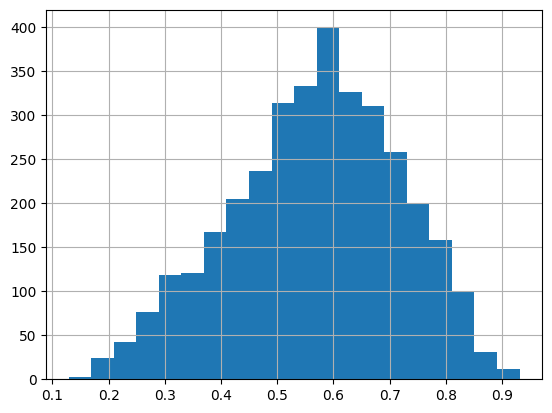

In [17]:
games_serving_out["p_home"].hist(bins=20)
games_serving_out.sample(5)[["date", "home_team", "away_team", "p_home", "p_away"]]